In [1]:
%matplotlib notebook
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
from typing import NamedTuple
from dataclasses import dataclass
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
plt.style.use('seaborn-notebook')
from matplotlib import colors

Compare line digitisation algorithms in terms of speed

In [3]:
# try to use namespaces
class Point(NamedTuple):
    """
    a point in 2D with x, y coords
    """

    x: float
    y: float

        
class Vector(NamedTuple):
    """
    a vector in 2D with x, y coords
    """

    x: float
    y: float
    
    def norm(self):
        return np.sqrt(self.x * self.x +
                       self.y * self.y)
    
    def mult(self, const):
        return Vector(const*self.x, const*self.y)
    
class Pixel(NamedTuple):
    """
    a point in 2D with x, y coords
    """

    x: int
    y: int        

### 1.Bresenham's line algorithm
This is the int positions version which is not that useful for my application

In [4]:
def bresenham_line(start_pixel, end_pixel):

    dx = abs(end_pixel.x - start_pixel.x)
    dy = abs(end_pixel.y - start_pixel.y)
    
    x, y = start_pixel.x, start_pixel.y

    sx = -1 if start_pixel.x > end_pixel.x else 1
    sy = -1 if start_pixel.y > end_pixel.y else 1
    
    line = []
    if dx > dy:
        err = dx / 10.0
        while int(np.floor(x)) != int(np.floor(end_pixel.x)):
            line.append(Point(int(x), int(y)))
            err -= dy
            if err < 0:
                y += sy
                err += dx
            x += sx
    else:
        err = dy / 2.0
        while int(np.floor(y)) != int(np.floor(end_pixel.y)):
            line.append(Point(int(x), int(y)))
            err -= dx
            if err < 0:
                x += sx
                err += dy
            y += sy       
            
    line.append(Point(int(x), int(y)))

    return line

A plotted example

In [75]:
def plot (start, end, algorithm):
    path_in_pixels = algorithm(start, end)

    data = np.zeros((7,7))
    fast = [pixel.x for pixel in path_in_pixels]
    slow = [pixel.y for pixel in path_in_pixels]
    data[fast, slow]=1

    fig, ax = plt.subplots()
    ax.imshow(data.T, extent=(0,7, 7, 0), origin='upper', cmap='viridis')
    ax.set_title(algorithm.__name__)
    # draw gridlines
    ax.grid(which='major', axis='both', linestyle='-', color='w', linewidth=2)

    plt.plot([start.x, end.x], [start.y, end.y], marker = 'o')

    plt.show()

<IPython.core.display.Javascript object>


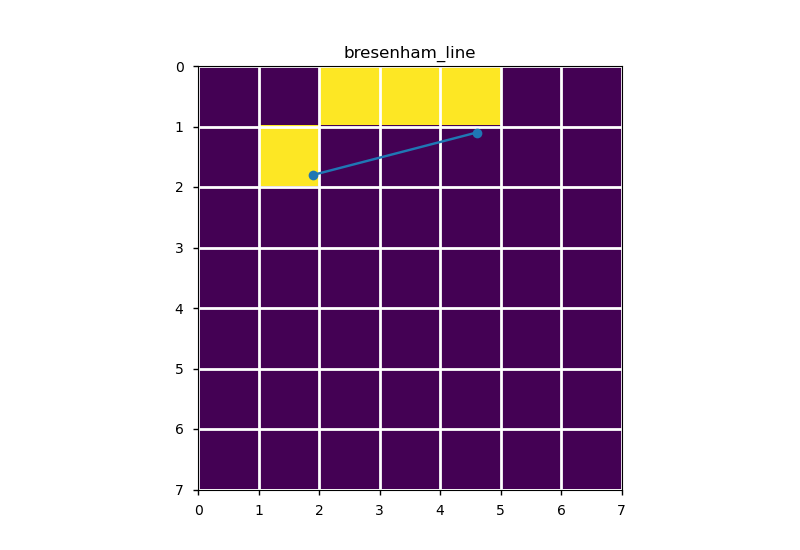

In [51]:
    start = Point(1.9,1.8)
    end = Point(4.6,1.1)
    
    plot(start, end, bresenham_line)

### 2.Naive algorithm
Just increase `x` by a given step size and add the new pixel in a set.
This is actually ok in terms of performance for a few pixel wide line
But it scales poorly especially for relatively slow step sizes

In [99]:
def naive_line(start, end):
    dx = end.x - start.x
    dy = end.y - start.y
    
    m = np.float32(dy)/dx 
    b = start.y - m * start.x
    
    x = start.x
    y = start.y
    line = {Pixel(int(x), int(y))}
    
    step = dx*0.01 
    
    while not ((int(x) == int(end.x)) and (int(y) == int(end.y))):
        x += step
        y = m*x + b
        line.add(Pixel(int(x), int(y)))
    return line  

<IPython.core.display.Javascript object>


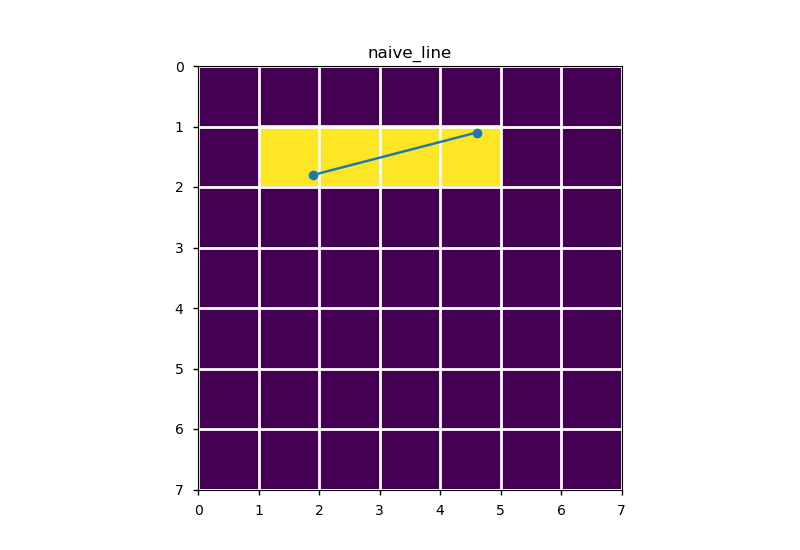

In [160]:
plot(start, end, naive_line)

### 3. ray equation
Ray equation describes a point t along its trajectory:

$point(t) = u + tv$

where u is the entry position and v is the direction of the ray.

We can start the traverse towards the pixel that is closest
_in units of t_ from starting point. This is done by adding a pixel
size in that direction also in units of t. Repeat until reaching
the exit pixel.

Voxels have unit size, ie units are in pixel size
such that stepX and stepY are -1 or 1

From the entry and exit positions one can determine v

ie $v = |exit - entry|$

#### 3.1 naive implementation

This implementation is based on https://github.com/cgyurgyik/fast-voxel-traversal-algorithm/blob/master/overview/FastVoxelTraversalOverview.md and documentation here is a good place to start to understand the algorithm. 

The version here allows all travelling direction quadrants. 

In [5]:
def traverse_pixels_v1(entry_pos, exit_pos):
    dx = exit_pos.x - entry_pos.x
    dy = exit_pos.y - entry_pos.y
    
    # set the travelling direction quadrant based on dx, dy signs
    if dx == 0:
        stepX = 0
        
        tDeltaX = np.inf
        tDeltaY = dy
        
        tmaxX = np.inf
        
    elif dy == 0:
        stepY = 0
        
        tDeltaX = dx
        tDeltaY = np.inf
        
        tmaxY = np.inf
        
    else:    
        norm = np.sqrt(dx*dx + dy*dy)

        # deltas are just the inverse component of t
        tDeltaX = norm/dx
        tDeltaY = norm/dy
        
    if dx < 0:
        stepX = -1
        tmaxX = (entry_pos.x - np.floor(entry_pos.x)) * tDeltaX
    elif dx > 0:
        stepX = 1
        tmaxX = (np.ceil(entry_pos.x) - entry_pos.x) * tDeltaX

    if dy < 0:
        stepY = -1
        tmaxY = (entry_pos.y - np.floor(entry_pos.y)) * tDeltaY
    elif dy > 0:
        stepY = 1
        tmaxY = (np.ceil(entry_pos.y) - entry_pos.y) * tDeltaY


    # list of pixels travelled
    x, y = int(entry_pos.x), int(entry_pos.y)
    line = [Pixel(x, y)]

    while not ((x == int(exit_pos.x)) and (y == int(exit_pos.y))):
        
        if abs(tmaxX) < abs(tmaxY):
            tmaxX += tDeltaX
            x += stepX
        elif abs(tmaxX) > abs(tmaxY):
            tmaxY += tDeltaY
            y += stepY
        else:
            x += stepX
            y += stepY
        
        line.append(Pixel(x,y))
        
    return line  

<IPython.core.display.Javascript object>


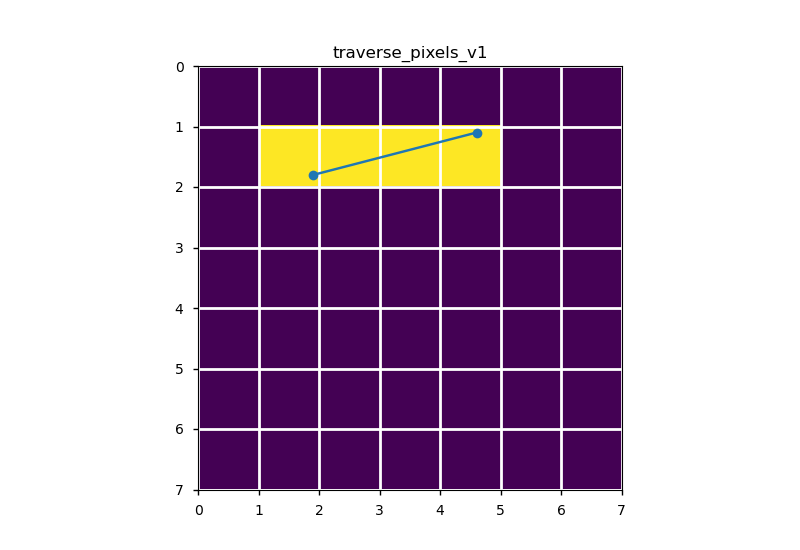

In [54]:
plot(start, end, traverse_pixels_v1)

##### Does replacing the while loop with a for loop does much? Small difference after 15 pixels

In [58]:
def traverse_pixels_v2_2(entry_pos, exit_pos):
    dx = exit_pos.x - entry_pos.x
    dy = exit_pos.y - entry_pos.y

    
    start_pixel = Pixel(int(entry_pos.x), int(entry_pos.y))
    end_pixel = Pixel(int(exit_pos.x), int(exit_pos.y))    
    
    x, y = start_pixel.x, start_pixel.y
    
    n = 0
    
    if dx == 0:      
        tDeltaX = np.inf
        tDeltaY = dy
        stepX = 0
        tmaxX = np.inf

    elif dy == 0:       
        tDeltaX = dx
        tDeltaY = np.inf
        stepY = 0
        tmaxY = np.inf

    else:
        norm = np.sqrt(dx*dx + dy*dy)
        # deltas are just the inverse component of v
        tDeltaX = norm/dx
        tDeltaY = norm/dy
        
    # set the travelling direction quadrant based on v
    if dx < 0:
        stepX = -1
        tmaxX = (entry_pos.x - np.floor(entry_pos.x)) * tDeltaX
        n += x - end_pixel.x
        
    elif dx > 0:
        stepX = 1
        tmaxX = (np.ceil(entry_pos.x) - entry_pos.x) * tDeltaX
        n += end_pixel.x - x

    if dy < 0:
        stepY = -1
        tmaxY = (entry_pos.y - np.floor(entry_pos.y)) * tDeltaY
        n += y - end_pixel.y
        
    elif dy > 0:
        stepY = 1
        tmaxY = (np.ceil(entry_pos.y) - entry_pos.y) * tDeltaY
        n += end_pixel.y - y
         
        
    # list of pixels travelled
    pixels = [Pixel(x, y)]

    for _ in range(n):
        if abs(tmaxX) < abs(tmaxY):
            tmaxX += tDeltaX
            x += stepX
        elif abs(tmaxX) > abs(tmaxY):
            tmaxY += tDeltaY
            y += stepY
        else:
            x += stepX
            y += stepY
        
        pixels.append(Pixel(x,y))
        
    return pixels

<IPython.core.display.Javascript object>


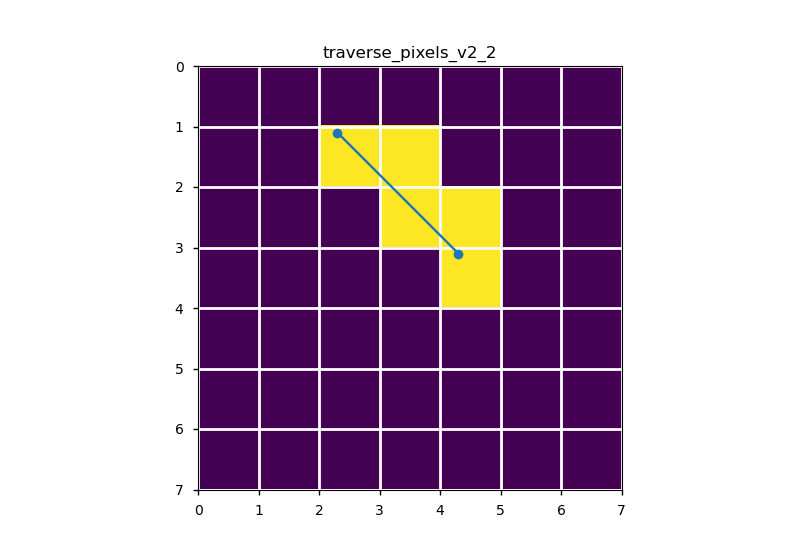

In [59]:
plot(Point(2.3,1.1), Point(4.3, 3.1), traverse_pixels_v2_2)

In [60]:
num_pixels = []
time_traverse2 = []
time_traverse2_sd = []
time_traverse22 = []
time_traverse22_sd = []


for distance in range(0,20, 2):
    start = Point(np.random.uniform(0,20), np.random.uniform(0,20))
    end = Point(np.random.uniform(0,20), np.random.uniform(0,20))
    print('start:', start)
    print('end:', end)
    num_pixels.append(len(traverse_pixels_v3(start, end)))
    
    time_traverse2_ = %timeit -n 1000 -r 1000 -o traverse_pixels_v2_1(start, end)
    time_traverse2.append(time_traverse2_.average)
    time_traverse2_sd.append(time_traverse2_.stdev)
    
    time_traverse22_ = %timeit -n 1000 -r 1000 -o traverse_pixels_v2_2(start, end)
    time_traverse22.append(time_traverse22_.average)
    time_traverse22_sd.append(time_traverse22_.stdev)
    
    print()

start: Point(x=18.73386363726561, y=15.718475263597043)
end: Point(x=5.133414467519581, y=7.524630026922052)
12.3 µs ± 270 ns per loop (mean ± std. dev. of 1000 runs, 1,000 loops each)
11.8 µs ± 164 ns per loop (mean ± std. dev. of 1000 runs, 1,000 loops each)

start: Point(x=13.165307212425558, y=12.832448251872112)
end: Point(x=7.6955500673891635, y=19.61670268705582)
8.89 µs ± 90 ns per loop (mean ± std. dev. of 1000 runs, 1,000 loops each)
8.85 µs ± 53.5 ns per loop (mean ± std. dev. of 1000 runs, 1,000 loops each)

start: Point(x=6.622193252653221, y=1.3005144129126367)
end: Point(x=9.036362146336463, y=4.867074778547796)
5.56 µs ± 38.6 ns per loop (mean ± std. dev. of 1000 runs, 1,000 loops each)
5.92 µs ± 47.5 ns per loop (mean ± std. dev. of 1000 runs, 1,000 loops each)

start: Point(x=11.926330395094485, y=16.7513669617978)
end: Point(x=18.514713875365118, y=16.63862166042904)
5.72 µs ± 36.3 ns per loop (mean ± std. dev. of 1000 runs, 1,000 loops each)
6.1 µs ± 51.9 ns per loo

<IPython.core.display.Javascript object>


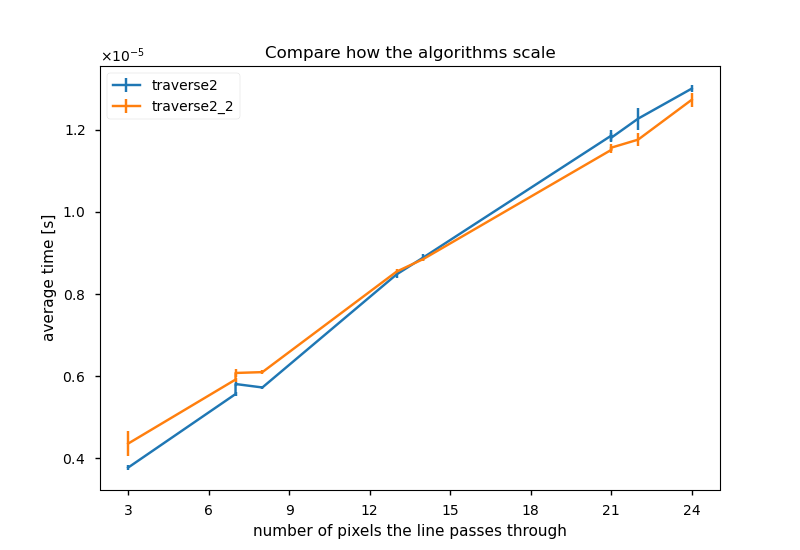

In [61]:
fig, ax = plt.subplots()

sorted_pix = np.argsort(num_pixels)

plt.errorbar(np.array(num_pixels)[sorted_pix], 
             np.array(time_traverse2)[sorted_pix], 
             yerr=np.array(time_traverse2_sd)[sorted_pix], 
             label='traverse2'
            )
#plt.scatter(num_pixels, time_traverse2, label='traverse2')
plt.errorbar(np.array(num_pixels)[sorted_pix],
             np.array(time_traverse22)[sorted_pix], 
             yerr=np.array(time_traverse22_sd)[sorted_pix], 
             label='traverse2_2')

plt.title(r'Compare how the algorithms scale')
plt.xlabel(r'number of pixels the line passes through')
plt.ylabel(r'average time [s]')

plt.ticklabel_format(axis='y', style='sci', useMathText=True, scilimits=(0,0))

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend()
plt.show()

##### Does moving the abs in main loop out do something?

In [83]:
def traverse_pixels_v2_3(entry_pos, exit_pos):
    dx = abs(exit_pos.x - entry_pos.x)
    dy = abs(exit_pos.y - entry_pos.y)


   
    start_pixel = Pixel(int(entry_pos.x), int(entry_pos.y))
    end_pixel = Pixel(int(exit_pos.x), int(exit_pos.y))    
    
    x, y = start_pixel.x, start_pixel.y
    
    n = 0
    
    
    if dx == 0:      
        tDeltaX = np.inf
        tDeltaY = dy
        stepX = 0
        tmaxX = np.inf

    elif dy == 0:       
        tDeltaX = dx
        tDeltaY = np.inf
        stepY = 0
        tmaxY = np.inf

    else:
        norm = np.sqrt(dx*dx + dy*dy)
        # deltas are just the inverse component of v
        tDeltaX = norm/dx
        tDeltaY = norm/dy
        
    # set the travelling direction quadrant based on v
    if exit_pos.x < entry_pos.x:
        stepX = -1
        tmaxX = abs((entry_pos.x - np.floor(entry_pos.x)) * tDeltaX)
        n += x - end_pixel.x
        
    elif exit_pos.x > entry_pos.x:
        stepX = 1
        tmaxX = abs((np.ceil(entry_pos.x) - entry_pos.x) * tDeltaX)
        n += end_pixel.x - x

    if exit_pos.y < entry_pos.y:
        stepY = -1
        tmaxY = abs((entry_pos.y - np.floor(entry_pos.y)) * tDeltaY)
        n += y - end_pixel.y
        
    elif exit_pos.y > entry_pos.y:
        stepY = 1
        tmaxY = abs((np.ceil(entry_pos.y) - entry_pos.y) * tDeltaY)
        n += end_pixel.y - y
        
        
    # list of pixels travelled
    pixels = [Pixel(x, y)]
    for _ in range(n):
        if tmaxX < tmaxY:
            tmaxX += tDeltaX
            x += stepX
        elif tmaxX > tmaxY:
            tmaxY += tDeltaY
            y += stepY
        else:
            tmaxX += tDeltaX
            x += stepX
            tmaxY += tDeltaY
            y += stepY
        
        pixels.append(Pixel(x,y))
        
    return pixels

<IPython.core.display.Javascript object>


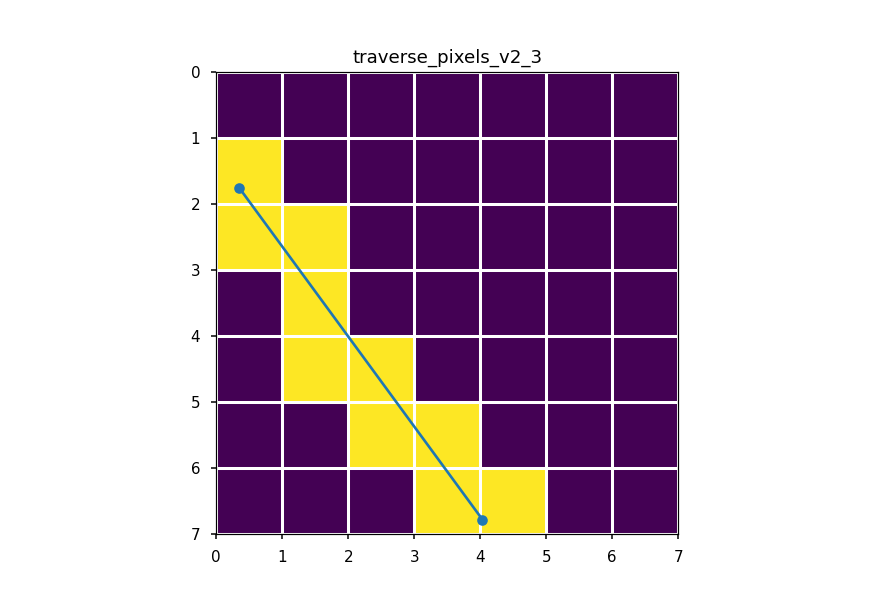

In [92]:
start = Point(np.random.uniform(0,7), np.random.uniform(0,7))
end = Point(np.random.uniform(0,7), np.random.uniform(0,7))
plot(start, end, traverse_pixels_v2_3)

In [64]:
num_pixels = []
time_traverse22 = []
time_traverse22_sd = []
time_traverse23 = []
time_traverse23_sd = []


for distance in range(0,20, 2):
    start = Point(np.random.uniform(0,20), np.random.uniform(0,20))
    end = Point(np.random.uniform(0,20), np.random.uniform(0,20))
    print('start:', start)
    print('end:', end)
    num_pixels.append(len(traverse_pixels_v3(start, end)))
    
    time_traverse22_ = %timeit -n 1000 -r 1000 -o traverse_pixels_v2_2(start, end)
    time_traverse22.append(time_traverse22_.average)
    time_traverse22_sd.append(time_traverse22_.stdev)
    
    time_traverse23_ = %timeit -n 1000 -r 1000 -o traverse_pixels_v2_3(start, end)
    time_traverse23.append(time_traverse23_.average)
    time_traverse23_sd.append(time_traverse23_.stdev)
    
    print()

start: Point(x=2.921597386070951, y=9.793377021253459)
end: Point(x=2.3718838516430374, y=6.591280569940046)
4.88 µs ± 159 ns per loop (mean ± std. dev. of 1000 runs, 1,000 loops each)
4.51 µs ± 54.3 ns per loop (mean ± std. dev. of 1000 runs, 1,000 loops each)

start: Point(x=10.56399726390477, y=13.430449196380469)
end: Point(x=7.531177199331516, y=14.063666384268604)
5.12 µs ± 73.2 ns per loop (mean ± std. dev. of 1000 runs, 1,000 loops each)
4.93 µs ± 55.9 ns per loop (mean ± std. dev. of 1000 runs, 1,000 loops each)

start: Point(x=15.192854261490403, y=5.095369726297189)
end: Point(x=5.082124148148313, y=9.318132152672277)
8.97 µs ± 230 ns per loop (mean ± std. dev. of 1000 runs, 1,000 loops each)
7.77 µs ± 41.4 ns per loop (mean ± std. dev. of 1000 runs, 1,000 loops each)

start: Point(x=10.392380308013607, y=15.200835501246225)
end: Point(x=18.22890648649191, y=11.318541964107055)
8.22 µs ± 50.7 ns per loop (mean ± std. dev. of 1000 runs, 1,000 loops each)
7.55 µs ± 36.9 ns per

<IPython.core.display.Javascript object>


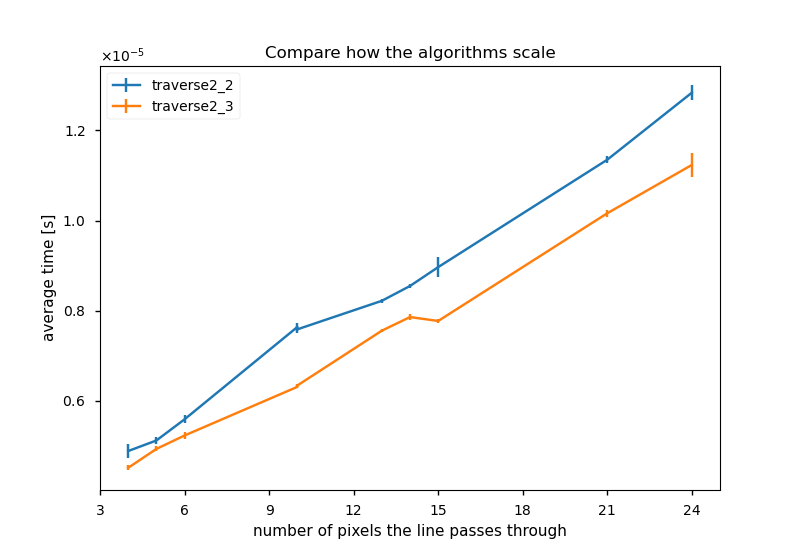

In [65]:
fig, ax = plt.subplots()

sorted_pix = np.argsort(num_pixels)

plt.errorbar(np.array(num_pixels)[sorted_pix], 
             np.array(time_traverse22)[sorted_pix], 
             yerr=np.array(time_traverse22_sd)[sorted_pix], 
             label='traverse2_2'
            )
#plt.scatter(num_pixels, time_traverse2, label='traverse2')
plt.errorbar(np.array(num_pixels)[sorted_pix],
             np.array(time_traverse23)[sorted_pix], 
             yerr=np.array(time_traverse23_sd)[sorted_pix], 
             label='traverse2_3')

plt.title(r'Compare how the algorithms scale')
plt.xlabel(r'number of pixels the line passes through')
plt.ylabel(r'average time [s]')

plt.ticklabel_format(axis='y', style='sci', useMathText=True, scilimits=(0,0))

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend()
plt.show()

#### 3.3 Actual optimisation. change units to reduce number of operations

In [4]:
def traverse_pixels_v3(entry_pos, exit_pos):

    dx = abs(exit_pos.x - entry_pos.x)
    dy = abs(exit_pos.y - entry_pos.y)
    
    start_pixel = Pixel(int(entry_pos.x), int(entry_pos.y))
    end_pixel = Pixel(int(exit_pos.x), int(exit_pos.y))    
    
    x, y = start_pixel.x, start_pixel.y

    # predict number of pixels
    n = 0
    
    if dx == 0:      
        error = np.inf
        stepX = 0

    elif exit_pos.x < entry_pos.x:
        stepX = -1
        error = abs((entry_pos.x - start_pixel.x) * dy)
        n += x - end_pixel.x

    else:
        stepX = 1
        error = abs((np.ceil(entry_pos.x) - entry_pos.x) * dy)
        n += end_pixel.x - x
        
    if dy == 0:       
        error -= np.inf
        stepY = 0

    elif exit_pos.y < entry_pos.y:
        stepY = -1
        error -= abs((entry_pos.y - start_pixel.y) * dx)
        n += y - end_pixel.y
            
    else:
        stepY = 1
        error -= abs((np.ceil(entry_pos.y) - entry_pos.y) * dx)
        n += end_pixel.y - y

    pixels = [start_pixel]
  
    for _ in range(n):
        if error < 0:
            error += dy
            x += stepX
        elif error > 0:
            error -= dx
            y += stepY
        else:
            x += stepX
            y += stepY

        pixels.append(Pixel(x,y))

    return pixels

### Compare speeds

In [69]:
num_pixels = []
time_traverse1 = []
time_traverse1_sd = []
time_traverse2 = []
time_traverse2_sd = []
time_traverse3 = []
time_traverse3_sd = []

for distance in range(0,30, 2):
    start = Point(np.random.uniform(0,20), np.random.uniform(0,20))
    end = Point(np.random.uniform(0,20), np.random.uniform(0,20))
    print('start:', start)
    print('end:', end)
    num_pixels.append(len(traverse_pixels_v3(start, end)))
    
    time_traverse1_ = %timeit -n 1000 -r 1000 -o traverse_pixels_v1(start, end)
    time_traverse1.append(time_traverse1_.average)
    time_traverse1_sd.append(time_traverse1_.stdev)
    
    time_traverse2_ = %timeit -n 1000 -r 1000 -o traverse_pixels_v2_3(start, end)
    time_traverse2.append(time_traverse2_.average)
    time_traverse2_sd.append(time_traverse2_.stdev)
    
    time_traverse3_ = %timeit -n 1000 -r 1000 -o traverse_pixels_v3(start, end)
    time_traverse3.append(time_traverse3_.average)
    time_traverse3_sd.append(time_traverse3_.stdev)
    
    print()

start: Point(x=18.481778353343806, y=6.953203667937222)
end: Point(x=19.75332462473067, y=4.370426764142135)
4.48 µs ± 271 ns per loop (mean ± std. dev. of 1000 runs, 1,000 loops each)
4.7 µs ± 54.2 ns per loop (mean ± std. dev. of 1000 runs, 1,000 loops each)
The slowest run took 4.97 times longer than the fastest. This could mean that an intermediate result is being cached.
4.12 µs ± 993 ns per loop (mean ± std. dev. of 1000 runs, 1,000 loops each)

start: Point(x=16.191645343264454, y=3.5492094600049606)
end: Point(x=3.126374854335039, y=17.214159599105784)
15.3 µs ± 114 ns per loop (mean ± std. dev. of 1000 runs, 1,000 loops each)
11.9 µs ± 65.6 ns per loop (mean ± std. dev. of 1000 runs, 1,000 loops each)
15.3 µs ± 69.5 ns per loop (mean ± std. dev. of 1000 runs, 1,000 loops each)

start: Point(x=18.797023964176102, y=2.741439275771118)
end: Point(x=14.917701268744459, y=16.284027946703578)
11.6 µs ± 91 ns per loop (mean ± std. dev. of 1000 runs, 1,000 loops each)
9.01 µs ± 39.8 n

<IPython.core.display.Javascript object>


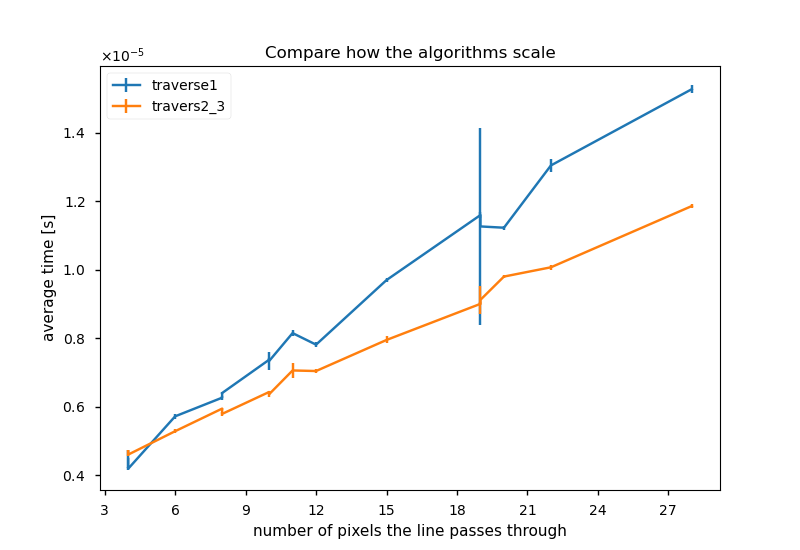

In [72]:
fig, ax = plt.subplots()

sorted_pix = np.argsort(num_pixels)

plt.errorbar(np.array(num_pixels)[sorted_pix], 
             np.array(time_traverse1)[sorted_pix], 
             yerr=np.array(time_traverse1_sd)[sorted_pix], 
             label='traverse1'
            )

plt.errorbar(np.array(num_pixels)[sorted_pix], 
             np.array(time_traverse2)[sorted_pix], 
             yerr=np.array(time_traverse2_sd)[sorted_pix], 
             label='travers2_3'
            )

# plt.errorbar(np.array(num_pixels)[sorted_pix],
#              np.array(time_traverse3)[sorted_pix], 
#              yerr=np.array(time_traverse3_sd)[sorted_pix], 
#              label='traverse3')

plt.title(r'Compare how the algorithms scale')
plt.xlabel(r'number of pixels the line passes through')
plt.ylabel(r'average time [s]')

plt.ticklabel_format(axis='y', style='sci', useMathText=True, scilimits=(0,0))

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend()
plt.show()

In [75]:
def traverse_pixels_v3_q1(entry_pos, exit_pos):

    d = Vector(abs(exit_pos.x - entry_pos.x),
               abs(exit_pos.y - entry_pos.y))
    
    start_pixel = Pixel(int(entry_pos.x), int(entry_pos.y))
    end_pixel = Pixel(int(exit_pos.x), int(exit_pos.y))    
    
    x, y = start_pixel.x, start_pixel.y

    # number of pixels
    n = 0
    
    if d.x == 0:      
        error = np.inf
        stepX = 0

    elif exit_pos.x < entry_pos.x:
        stepX = -1
        error = abs((entry_pos.x - start_pixel.x) * d.y)
        n += x - end_pixel.x

    else:
        stepX = 1
        error = abs((np.ceil(entry_pos.x) - entry_pos.x) * d.y)
        n += end_pixel.x - x
        
    if d.y == 0:       
        error -= np.inf
        stepY = 0

    elif exit_pos.y < entry_pos.y:
        stepY = -1
        error -= abs((entry_pos.y - start_pixel.y) * d.x)
        n += y - end_pixel.y
            
    else:
        stepY = 1
        error -= abs((np.ceil(entry_pos.y) - entry_pos.y) * d.x)
        n += end_pixel.y - y

    if d.x == d.y:
        # straight diagonal
        n = n//2 + 1
        
    pixels = [start_pixel]
  
    for _ in range(n):
        error += d.y
        x += stepX

        pixels.append(Pixel(x,y))

    return pixels

<IPython.core.display.Javascript object>


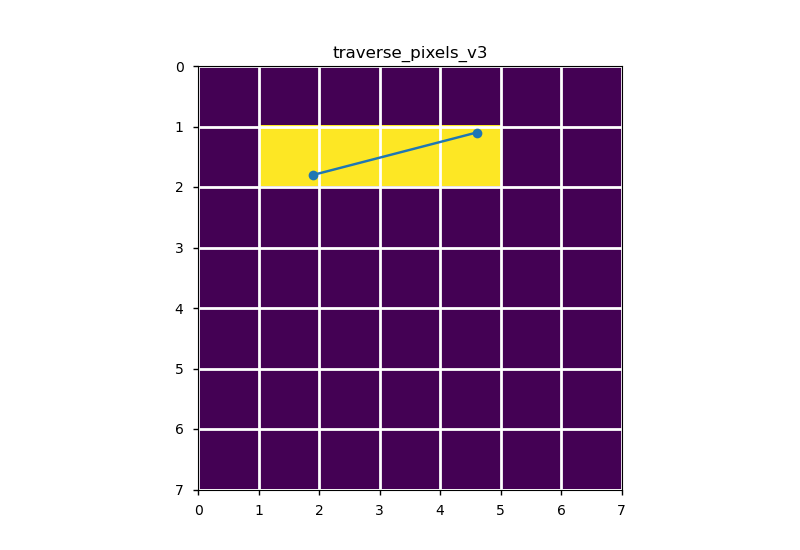

In [71]:
plot(start, end, traverse_pixels_v3)

In [61]:
def david(entry_pos, exit_pos):
    # only for one quadrant
    start_pixel = Pixel(int(entry_pos.x), int(entry_pos.y))
    end_pixel = Pixel(int(exit_pos.x), int(exit_pos.y))    
    
    x, y = start_pixel.x, start_pixel.y
    
    pixels = {start_pixel}
    
    dx = exit_pos.x - entry_pos.x
    dy = exit_pos.y - entry_pos.y
    
    m = np.float32(dy)/dx 
    b = entry_pos.y - m * entry_pos.x
    
    
    while not x == int(exit_pos.x)+1:
        x += 1
        ynew = int(m*x + b)
        
        pixels.add(Pixel(x-1, ynew))
        pixels.add(Pixel(x, ynew))
        
        if ynew - y > 1:
            for yi in range(y, ynew):
                pixels.add(Pixel(x-1, yi))
        y = ynew        
    
    wrong_pixel = Pixel(int(exit_pos.x)+1, int(exit_pos.y))
    if wrong_pixel in pixels:
        pixels.remove(wrong_pixel)        
    return list(pixels)

## time algorithms versus number of pixels

In [104]:
num_pixels = []
time_gs = []
time_naive = []
time_traverse = []

for distance in range(0,50, 5):
    start = Point(np.random.uniform(0,20), np.random.uniform(0,20))
    end = Point(np.random.uniform(0,20), np.random.uniform(0,20))
    print('start:', start)
    print('end:', end)
    num_pixels.append(len(traverse_pixels_v3(start, end)))
    time_gs_ = %timeit -n 1000 -r 100 -o bresenham_line(start, end)
    time_gs.append(time_gs_.average)
    
    time_traverse_ = %timeit -n 1000 -r 100 -o traverse_pixels_v3(start, end)
    time_traverse.append(time_traverse_.average)
    
    time_naive_ = %timeit -n 1000 -r 100 -o naive_line(start, end)
    time_naive.append(time_naive_.average)
    
    print()

start: Point(x=8.873370354455206, y=13.977837992871262)
end: Point(x=15.486136318787251, y=9.401905879034388)
12.3 µs ± 300 ns per loop (mean ± std. dev. of 100 runs, 1000 loops each)
9.06 µs ± 309 ns per loop (mean ± std. dev. of 100 runs, 1000 loops each)
57.3 µs ± 1.85 µs per loop (mean ± std. dev. of 100 runs, 1000 loops each)

start: Point(x=17.91367867157233, y=4.795005986425518)
end: Point(x=7.352849052945407, y=10.471907866819157)
17.3 µs ± 493 ns per loop (mean ± std. dev. of 100 runs, 1000 loops each)
11.9 µs ± 586 ns per loop (mean ± std. dev. of 100 runs, 1000 loops each)
58.4 µs ± 1.82 µs per loop (mean ± std. dev. of 100 runs, 1000 loops each)

start: Point(x=10.772118097791148, y=6.764557374810809)
end: Point(x=0.17435411964863645, y=13.439336107446334)
18.5 µs ± 768 ns per loop (mean ± std. dev. of 100 runs, 1000 loops each)
13.4 µs ± 192 ns per loop (mean ± std. dev. of 100 runs, 1000 loops each)
61.7 µs ± 1.21 µs per loop (mean ± std. dev. of 100 runs, 1000 loops each

<IPython.core.display.Javascript object>


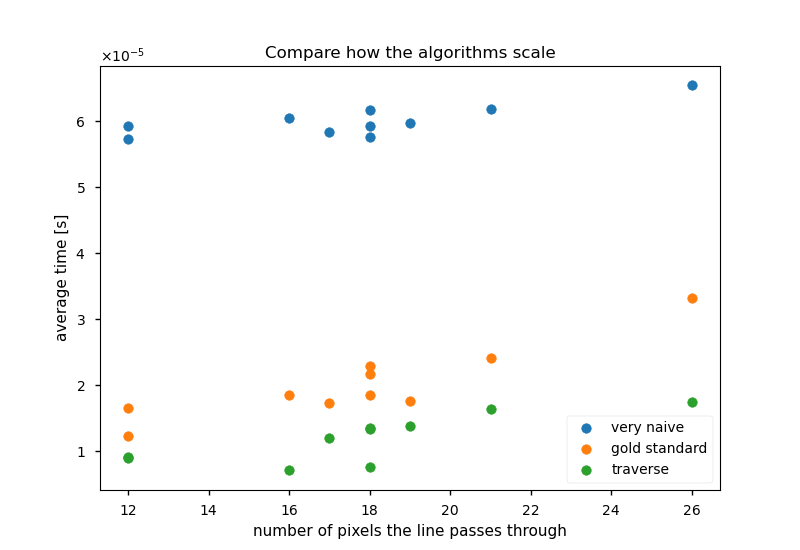

In [105]:
fig, ax = plt.subplots()

plt.scatter(num_pixels, time_naive, label='very naive')
plt.scatter(num_pixels, time_gs, label='gold standard')
plt.scatter(num_pixels, time_traverse, label='traverse')

plt.title(r'Compare how the algorithms scale')
plt.xlabel(r'number of pixels the line passes through')
plt.ylabel(r'average time [s]')

plt.ticklabel_format(axis='y', style='sci', useMathText=True, scilimits=(0,0))

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend()
plt.show()

## traverse vs david but only in quadrant 1

In [115]:
time_david = []
time_traverseq1 = []
num_pixels = []

start = Point(0.1, 0.1)

for distance in range(0,50,2):

    end = Point(np.random.uniform(0,20), np.random.uniform(0,20))

    print(end)
    num_pixels.append(len(traverse_pixels_v3(start, end)))
    
    time_traverseq1_ = %timeit -n 1000 -r 100 -o traverse_pixels_v3_q1(start, end)
    time_traverseq1.append(time_traverseq1_.average)
    
    time_david_ = %timeit -n 1000 -r 100 -o david(start, end)
    time_david.append(time_david_.average)
    
    print()

Point(x=8.20501443179986, y=1.1840547184731554)
6.57 µs ± 151 ns per loop (mean ± std. dev. of 100 runs, 1000 loops each)
12.1 µs ± 185 ns per loop (mean ± std. dev. of 100 runs, 1000 loops each)

Point(x=14.22102134076673, y=5.493800537970763)
10.5 µs ± 197 ns per loop (mean ± std. dev. of 100 runs, 1000 loops each)
18.5 µs ± 181 ns per loop (mean ± std. dev. of 100 runs, 1000 loops each)

Point(x=4.7157404316696745, y=7.334761581177678)
7.42 µs ± 96.2 ns per loop (mean ± std. dev. of 100 runs, 1000 loops each)
9.91 µs ± 76.6 ns per loop (mean ± std. dev. of 100 runs, 1000 loops each)

Point(x=19.820654652281455, y=5.475924233399494)
12.4 µs ± 110 ns per loop (mean ± std. dev. of 100 runs, 1000 loops each)
22.8 µs ± 455 ns per loop (mean ± std. dev. of 100 runs, 1000 loops each)

Point(x=12.625539801357386, y=2.8436716623568525)
8.53 µs ± 83 ns per loop (mean ± std. dev. of 100 runs, 1000 loops each)
15.8 µs ± 166 ns per loop (mean ± std. dev. of 100 runs, 1000 loops each)

Point(x=9.

<IPython.core.display.Javascript object>


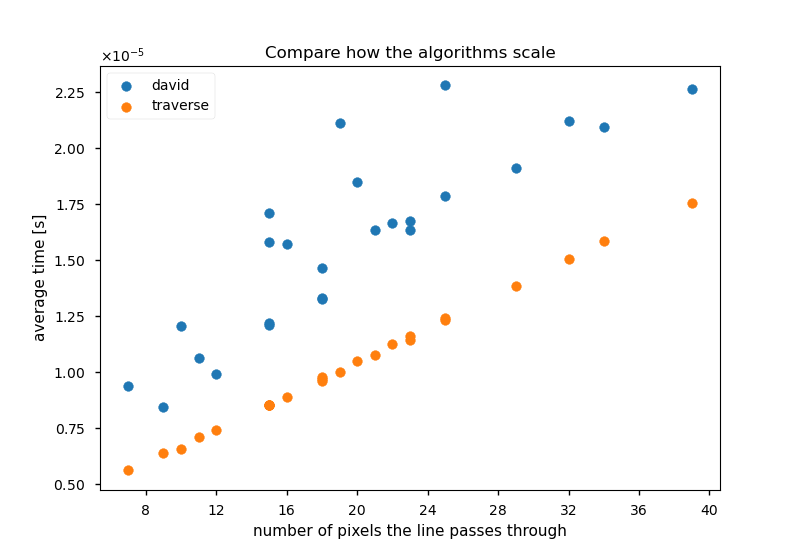

In [117]:
fig, ax = plt.subplots()

plt.scatter(num_pixels, time_david, label='david')
plt.scatter(num_pixels, time_traverseq1, label='traverse')

plt.title(r'Compare how the algorithms scale')
plt.xlabel(r'number of pixels the line passes through')
plt.ylabel(r'average time [s]')

plt.ticklabel_format(axis='y', style='sci', useMathText=True, scilimits=(0,0))

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend()
plt.show()

In [54]:
   
def pl_per_pixel_traversed_0(entry_pos, exit_pos):


    dx = abs(exit_pos.x - entry_pos.x)
    dy = abs(exit_pos.y - entry_pos.y)
    
    start_pixel = Pixel(int(entry_pos.x), int(entry_pos.y))
    end_pixel = Pixel(int(exit_pos.x), int(exit_pos.y))    
    
    x, y = start_pixel.x, start_pixel.y
    
    n = 0
  
    norm = np.sqrt(dx*dx + dy*dy)
    
    if dx == 0:      
        tDeltaX = np.inf
        tDeltaY = dy
        stepX = 0
        tmaxX = np.inf

    elif dy == 0:       
        tDeltaX = dx
        tDeltaY = np.inf
        stepY = 0
        tmaxY = np.inf

    else:
        # deltas are just the inverse component of v
        tDeltaX = norm/dx
        tDeltaY = norm/dy
        
    # set the travelling direction quadrant based on v
    if exit_pos.x < entry_pos.x:
        stepX = -1
        tmaxX = abs((entry_pos.x - np.floor(entry_pos.x)) * tDeltaX)
        n += x - end_pixel.x
        
    elif exit_pos.x > entry_pos.x:
        stepX = 1
        tmaxX = abs((np.ceil(entry_pos.x) - entry_pos.x) * tDeltaX)
        n += end_pixel.x - x

    if exit_pos.y < entry_pos.y:
        stepY = -1
        tmaxY = abs((entry_pos.y - np.floor(entry_pos.y)) * tDeltaY)
        n += y - end_pixel.y
        
    elif exit_pos.y > entry_pos.y:
        stepY = 1
        tmaxY = abs((np.ceil(entry_pos.y) - entry_pos.y) * tDeltaY)
        n += end_pixel.y - y

    v = Vector(dx/norm, dy/norm)
    x, y = int(entry_pos.x), int(entry_pos.y)
    pixels = [start_pixel]
    pixels = [Pixel(x, y)]
    path_lengths, prev_pl, total_pl = [], 0, 0
    for _ in range(n):

        if abs(tmaxX) < abs(tmaxY):
            total_pl = abs(tmaxX) 
            tmaxX += tDeltaX
            x += stepX
        elif abs(tmaxX) > abs(tmaxY):
            total_pl = abs(tmaxY)
            tmaxY += tDeltaY
            y += stepY
        else:
            total_pl = abs(tmaxX)
            x += stepX
            y += stepY
        
        pixels.append(Pixel(x,y))
        
        path_lengths.append(v.mult(total_pl-prev_pl).norm())
        prev_pl = total_pl

    path_lengths.append(v.mult(norm-total_pl).norm())
    return pixels, path_lengths   

In [50]:
def pl_per_pixel_traversed_1(entry_pos, exit_pos):

    dx = abs(exit_pos.x - entry_pos.x)
    dy = abs(exit_pos.y - entry_pos.y)
    
    start_pixel = Pixel(int(entry_pos.x), int(entry_pos.y))
    end_pixel = Pixel(int(exit_pos.x), int(exit_pos.y))    
    
    x, y = start_pixel.x, start_pixel.y
    
    n = 0
  
    norm = np.sqrt(dx*dx + dy*dy)
    
    if dx == 0:      
        tDeltaX = np.inf
        tDeltaY = dy
        stepX = 0
        tmaxX = np.inf

    elif dy == 0:       
        tDeltaX = dx
        tDeltaY = np.inf
        stepY = 0
        tmaxY = np.inf

    else:
        # deltas are just the inverse component of d
        tDeltaX = norm/dx
        tDeltaY = norm/dy
        
    # set the travelling direction quadrant based on d
    if exit_pos.x < entry_pos.x:
        stepX = -1
        tmaxX = abs((entry_pos.x - np.floor(entry_pos.x)) * tDeltaX)
        n += x - end_pixel.x
        
    elif exit_pos.x > entry_pos.x:
        stepX = 1
        tmaxX = abs((np.ceil(entry_pos.x) - entry_pos.x) * tDeltaX)
        n += end_pixel.x - x

    if exit_pos.y < entry_pos.y:
        stepY = -1
        tmaxY = abs((entry_pos.y - np.floor(entry_pos.y)) * tDeltaY)
        n += y - end_pixel.y
        
    elif exit_pos.y > entry_pos.y:
        stepY = 1
        tmaxY = abs((np.ceil(entry_pos.y) - entry_pos.y) * tDeltaY)
        n += end_pixel.y - y

    v = [dx/norm, dy/norm]
    x, y = int(entry_pos.x), int(entry_pos.y)
    pixels = [start_pixel]

    px_t, prev_pl, total_pl = [], 0, 0
    
    for _ in range(n):
        if tmaxX < tmaxY:
            total_pl = tmaxX 
            tmaxX += tDeltaX
            x += stepX
        elif tmaxX > tmaxY:
            total_pl = tmaxY
            tmaxY += tDeltaY
            y += stepY
        else:
            total_pl = tmaxX
            x += stepX
            y += stepY
        
        pixels.append(Pixel(x,y))
        
        px_t.append(total_pl - prev_pl)
        
        prev_pl = total_pl

    # last pixel path length in t units
    px_t.append(norm - total_pl)
    
    px_path_lens = np.linalg.norm(np.multiply.outer(px_t, v), axis=1)
    
    return pixels, px_path_lens  

In [55]:
pixels, pls = pl_per_pixel_traversed_0(Point(1.5, 2.5), Point(2.5, 4.6))
print(pixels)
print()
print(pls)

[Pixel(x=1, y=2), Pixel(x=1, y=3), Pixel(x=2, y=3), Pixel(x=2, y=4)]

[0.5537953976006194, 0.6091749373606812, 0.49841585784055753, 0.664554477120743]


In [56]:
pixels, pls = pl_per_pixel_traversed_1(Point(1.5, 2.5), Point(2.5, 4.6))
print(pixels)
print()
print(pls)

[Pixel(x=1, y=2), Pixel(x=1, y=3), Pixel(x=2, y=3), Pixel(x=2, y=4)]

[0.5537954  0.60917494 0.49841586 0.66455448]


In [57]:
time_pl0 = []
time_pl0_sd = []
time_pl1 = []
time_pl1_sd = []
time_pl2 = []
time_pl2_sd = []
num_pixels = []

start = Point(0.1, 0.1)

for distance in range(0,30,2):

    end = Point(np.random.uniform(0,20), np.random.uniform(0,20))

    print(end)
    num_pixels.append(len(traverse_pixels_v3(start, end)))
    
    time_pl0_ = %timeit -n 1000 -r 100 -o pl_per_pixel_traversed_0(start, end)
    time_pl0.append(time_pl0_.average)
    time_pl0_sd.append(time_pl0_.stdev)
    
    time_pl1_ = %timeit -n 1000 -r 100 -o pl_per_pixel_traversed_1(start, end)
    time_pl1.append(time_pl1_.average)
    time_pl1_sd.append(time_pl1_.stdev)
    
    print()

Point(x=3.660973778464227, y=15.279335601183078)
45.2 µs ± 1.56 µs per loop (mean ± std. dev. of 100 runs, 1,000 loops each)
20.4 µs ± 209 ns per loop (mean ± std. dev. of 100 runs, 1,000 loops each)

Point(x=3.8615358370674713, y=15.215365797182113)
44.3 µs ± 353 ns per loop (mean ± std. dev. of 100 runs, 1,000 loops each)
20.8 µs ± 196 ns per loop (mean ± std. dev. of 100 runs, 1,000 loops each)

Point(x=13.429926692635771, y=6.002176465292488)
45.4 µs ± 513 ns per loop (mean ± std. dev. of 100 runs, 1,000 loops each)
20.2 µs ± 227 ns per loop (mean ± std. dev. of 100 runs, 1,000 loops each)

Point(x=16.687863055634768, y=4.9346115377669975)
47 µs ± 395 ns per loop (mean ± std. dev. of 100 runs, 1,000 loops each)
21.4 µs ± 247 ns per loop (mean ± std. dev. of 100 runs, 1,000 loops each)

Point(x=11.521791629712311, y=14.944342662185798)
58.4 µs ± 495 ns per loop (mean ± std. dev. of 100 runs, 1,000 loops each)
24 µs ± 266 ns per loop (mean ± std. dev. of 100 runs, 1,000 loops each)



<IPython.core.display.Javascript object>


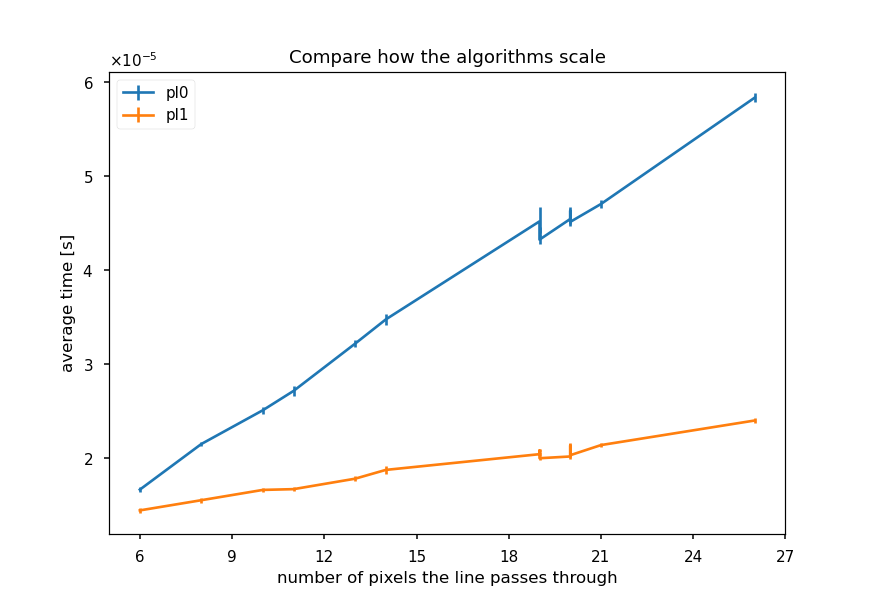

In [58]:
fig, ax = plt.subplots()

sorted_pix = np.argsort(num_pixels)

plt.errorbar(np.array(num_pixels)[sorted_pix], 
             np.array(time_pl0)[sorted_pix], 
             yerr=np.array(time_pl0_sd)[sorted_pix], 
             label='pl0'
            )

plt.errorbar(np.array(num_pixels)[sorted_pix],
             np.array(time_pl1)[sorted_pix], 
             yerr=np.array(time_pl1_sd)[sorted_pix], 
             label='pl1')

plt.title(r'Compare how the algorithms scale')
plt.xlabel(r'number of pixels the line passes through')
plt.ylabel(r'average time [s]')

plt.ticklabel_format(axis='y', style='sci', useMathText=True, scilimits=(0,0))

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend()
plt.show()